## Image Classification on **Fast, Furious, and Insured** and **Car Parts and Car Damages**

### 1. Setup and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os,time,random
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import layers, Input, models, callbacks, regularizers,initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,MaxPooling2D,Conv2D,SeparableConv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# utility code

# -------------------------
# Reproducibility settings
# -------------------------

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

### Ploting utilities for analyzing results

In [2]:
def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

### Wrapper for Training and Testing

In [11]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model,
                   epochs        = 500,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer=opt,
                  loss="binary_crossentropy",
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )


    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]

    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    # Print Confusion Matrix of the predictions
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0]).plot()

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

In [4]:
# Extract data from the train and test csv files
df_train = pd.read_csv(r"C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\Fast_Furious_Insured\train.csv")
df_test = pd.read_csv(r"C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\Fast_Furious_Insured\test.csv")

### Building Image Condition Dictionary

In [5]:
# Build dataframe of absolute image paths + damage flag
dataset_root = Path(r"C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\Fast_Furious_Insured")
train_image_dir = dataset_root / "trainImages"

image_df = (
    df_train.loc[:, ["Image_path", "Condition"]]
            .rename(columns={"Image_path": "image_path", "Condition": "condition"})
            .assign(
                image_path=lambda d: d["image_path"].apply(
                    lambda name: str((train_image_dir / name).resolve())
                )
            )
)

# keep only rows whose images actually exist
image_df = image_df[image_df["image_path"].apply(lambda p: Path(p).is_file())].reset_index(drop=True)

print(f"Rows with images present: {len(image_df):,}")
print(image_df.head())

Rows with images present: 1,399
                                          image_path  condition
0  C:\Users\JT von Seggern\DS Masters Repos\799S-...          0
1  C:\Users\JT von Seggern\DS Masters Repos\799S-...          1
2  C:\Users\JT von Seggern\DS Masters Repos\799S-...          0
3  C:\Users\JT von Seggern\DS Masters Repos\799S-...          1
4  C:\Users\JT von Seggern\DS Masters Repos\799S-...          1


In [15]:
def load_data_from_dataframe(image_df, img_size=(150, 150)):
    """
    Load images referenced in `image_df` and return normalized tensors + labels.
    Columns required:
      - image_path: absolute (or relative) path to the image file
      - condition: binary label (0 = no damage, 1 = damage)
    """
    X, y = [], []

    for _, row in image_df.iterrows():
        img_path = Path(row["image_path"])
        if not img_path.is_file():
            continue  # already filtered, but stay defensive

        label = int(row["condition"])
        img = load_img(img_path, target_size=img_size, interpolation="bilinear")
        arr = img_to_array(img)
        X.append(arr)
        y.append(label)

    if not X:
        raise ValueError("No images were loaded. Check image_df paths.")

    X = np.array(X, dtype="float32") / 255.0
    y = np.array(y, dtype="int32")
    return X, y


def show_counts(name, labels):
    counts = dict(Counter(labels.tolist() if hasattr(labels, "tolist") else labels))
    print(f"{name} per-class counts: {counts}")


# load tensors + labels and create splits used downstream
X_train_all, y_train_all = load_data_from_dataframe(image_df, img_size=(150, 150))
class_names = ["not_damaged", "damaged"]

print("Loaded tensors:", X_train_all.shape, y_train_all.shape)
show_counts("training", y_train_all)

# 70/15/15 split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_train_all, y_train_all,
    test_size=0.20,
    stratify=y_train_all,
    random_state=random_seed,
    shuffle=True,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=random_seed,
    shuffle=True,
)

print("Train / Val / Test shapes:", X_train.shape, X_val.shape, X_test.shape)
show_counts("train", y_train)
show_counts("val", y_val)
show_counts("test", y_test)

Loaded tensors: (1399, 150, 150, 3) (1399,)
training per-class counts: {0: 99, 1: 1300}
Train / Val / Test shapes: (1119, 150, 150, 3) (140, 150, 150, 3) (140, 150, 150, 3)
train per-class counts: {1: 1040, 0: 79}
val per-class counts: {1: 130, 0: 10}
test per-class counts: {1: 130, 0: 10}


### Examine the Dataset

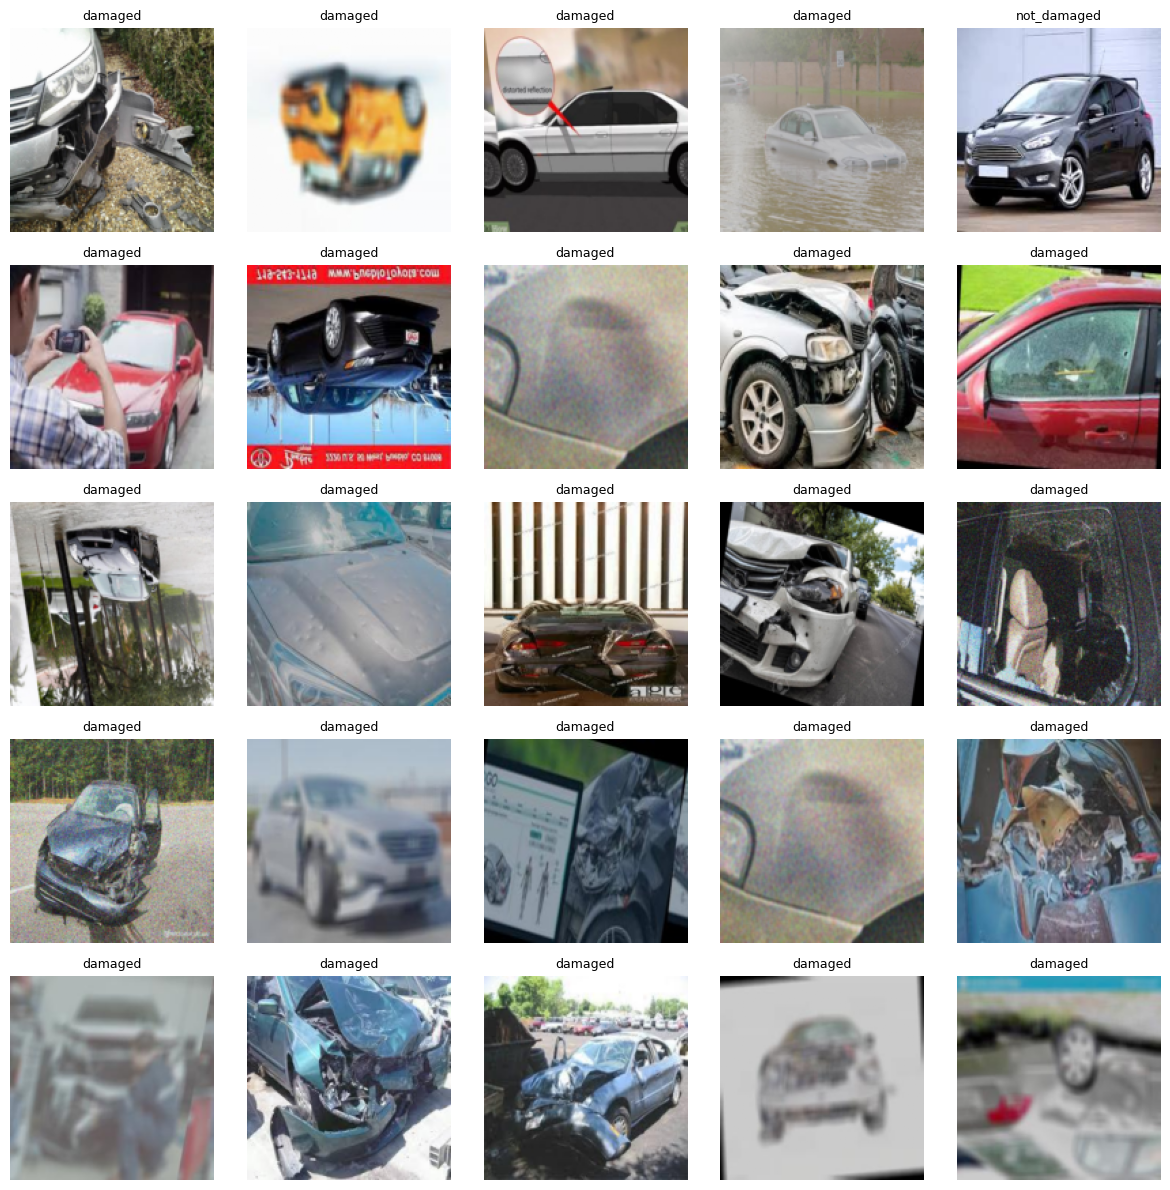

In [7]:
# Show a 5×5 grid of 25 random training images
plt.figure(figsize=(12, 12))
for i in range(25):
    rand_int = random.randint(0, X_train.shape[0] - 1)
    ax = plt.subplot(5, 5, i + 1)
    # X_train is already a NumPy array [0–1], so no .numpy() needed
    plt.imshow(X_train[rand_int])
    # pick the class name from your class_names list
    plt.title(class_names[y_train[rand_int]], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Baseline CNN


Baseline Model



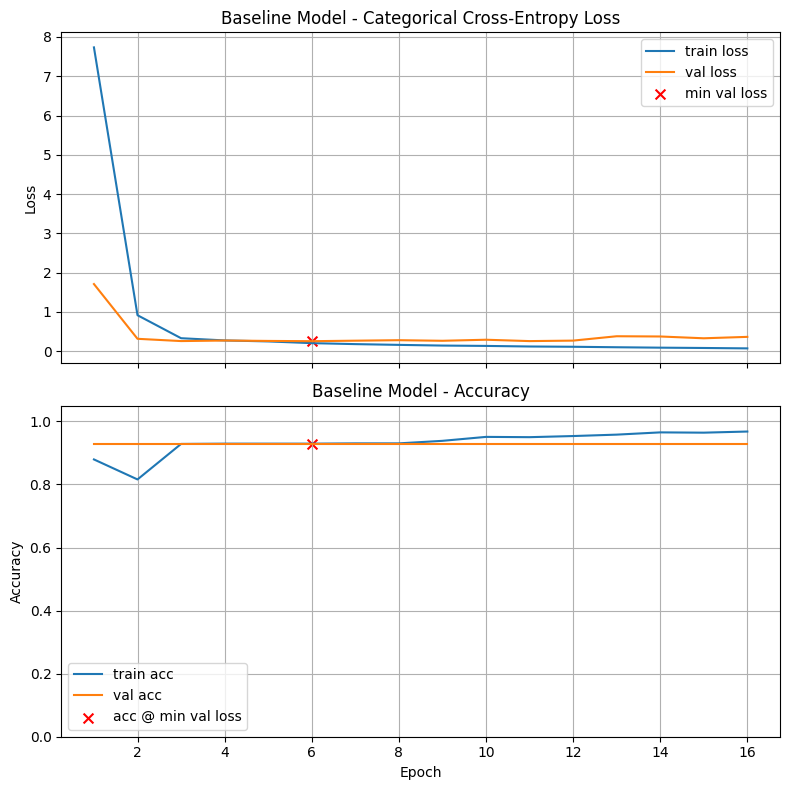

Final Training Loss:            0.0702
Final Training Accuracy:        0.9678
Final Validation Loss:          0.3634
Final Validation Accuracy:      0.9286
Minimum Validation Loss:        0.2532 (Epoch 6)
Validation Accuracy @ Min Loss: 0.9286
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Test Loss: 0.2648
Test Accuracy: 0.9286

Validation-Test Gap (accuracy): 0.000000


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [12]:
he = initializers.HeNormal()                                # best initializer for relu

model_baseline= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

train_and_test(model_baseline,title="Baseline Model")